In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg

Generate a random (stable) IIR filter
--------------

In [2]:
B_len = np.random.randint(5, 10)
A_len = np.random.randint(5, 10)

B = np.random.randn(B_len)
A = np.random.randn(A_len)

In [3]:
def stable_poly(length):
    # all roots inside unit circle and real valued polynomial
    
    roots = np.random.rand((length - 1) // 2) * np.exp(np.random.rand((length - 1) // 2) * 2j * np.pi)
    roots = np.hstack([roots, np.conj(roots)])
    if length % 2 == 0:
        roots = np.hstack([roots, np.random.rand(1) * 2 - 1])
    return np.poly(roots)

In [4]:
A = stable_poly(A_len)

In [5]:
B = stable_poly(B_len) * np.random.randn(1)

In [6]:
stable = (np.abs(np.roots(A)) < 1).all()
stable

True

In [7]:
minphase = (np.abs(np.roots(B)) < 1).all()
minphase

True

In [8]:
N = 100000

In [9]:
def iir_filter(x, B, A, N, y=None):
    if y is None:
        out = np.zeros(N)
        start = 0
    else:
        start = len(y)
        out = np.zeros(N + start)
        out[:start] = y
    
    for i in range(start, N + start):
        o = 0

        for j in range(max(0, i - len(x) + 1), min(i + 1, len(B))):
            o += B[j] * x[i - j]

        for j in range(1, min(i + 1, len(A))):
            o -= A[j] * out[i - j]

        out[i] = o / A[0]
        
    return out

In [10]:
out = iir_filter([1], B, A, N)

In [11]:
plt.figure()
plt.plot(out)

<IPython.core.display.Javascript object>

In [12]:
#signal = np.random.randn(N)
signal = np.random.rand(N) > 0.5
out = iir_filter(signal, B, A, N)

plt.figure()
plt.plot(out)

<IPython.core.display.Javascript object>

Self Tuning Regulator
---------------------

### NLMS IIR System Identification

In [13]:
n = max(A_len, B_len)

In [14]:
mu = 1

In [15]:
omega = np.zeros(A_len + B_len - 1)#np.random.randn(A_len + B_len - 1)

In [16]:
errors = []

In [17]:
for n in range(max(A_len, B_len), N):
    z = np.hstack([out[n - 1:n - A_len:-1], signal[n:n - B_len:-1]])

    A_est = np.hstack([1, -omega[:A_len - 1]])
    B_est = omega[A_len - 1:]

    y_est = iir_filter(signal[n - max(A_len, B_len):n + 1], B_est, A_est, 1, out[n - max(A_len, B_len):n])

    e = out[n] - y_est[-1]

    errors.append(e)

    omega = omega + mu / np.dot(z, z) * e * z

In [18]:
plt.figure()
plt.plot(errors)

<IPython.core.display.Javascript object>

In [19]:
A_est, A, B_est, B

(array([ 1.        ,  0.83097298,  0.37671551]),
 array([ 1.        ,  0.77531671,  0.3771521 ]),
 array([ 1.46257817, -2.64463162,  2.44939817, -0.89754248,  0.08666767,
         0.08197832,  0.02161541, -0.04955916,  0.02768101]),
 array([  1.46527098e+00,  -2.72733456e+00,   2.66855694e+00,
         -1.18901015e+00,   2.98365538e-01,   1.05748340e-02,
         -1.30880244e-04,  -1.57631446e-04,   8.44578995e-06]))

In [20]:
plt.figure()
plt.plot(signal)

<IPython.core.display.Javascript object>

Let's try fixed regulation with the estimated filter
----------------------------------------------------

In [21]:
N = 1000

In [22]:
y_ref = np.ones(N) * 80

In [23]:
u = iir_filter(y_ref, A_est, B_est, N)

In [24]:
y = iir_filter(u, B, A, N)

In [25]:
plt.figure()
plt.plot(y)
plt.ylim(0, 100)

<IPython.core.display.Javascript object>

(0, 100)

works with some bias

Now we regulate while identifying the system
--------------------------------------------

In [26]:
mu = 0.01
N = 100000

In [27]:
y_ref = np.ones(N) * 50

In [28]:
#omega = np.zeros(A_len + B_len - 1) # start with zeros => division by zero error
#omega = np.random.randn(A_len + B_len - 1) # start with random noise => unstable controller
#omega = np.hstack([-A[1:], B]) # start with a perfect estimate -> nothing to do for the adaptation algorithm - works
omega = np.hstack([-stable_poly(A_len)[1:], stable_poly(B_len)]) # => start with stable and minimal phase controller - doesn't work :()

In [29]:
u = []
y = []
errors = []
y_ref = []

for n in range(N):
    y_ref.append(np.random.randn(1))
    
    if n < max(A_len, B_len):
        #u.append(1)
        u.append(np.random.randn(1))
        y = iir_filter(u, B, A, 1, y)
        errors.append(y[-1] - y_ref[-1])
    else:
        A_est = np.hstack([1, -omega[:A_len - 1]])
        B_est = omega[A_len - 1:]

        u = iir_filter(y_ref, A_est, B_est, 1, u)
        
        #u[-1] = float(u[-1] > 0.5)
        
        y = iir_filter(u, B, A, 1, y)

        z = np.hstack([y[n - 1:n - A_len:-1], u[n:n - B_len:-1]])
        y_est = iir_filter(u[n - max(A_len, B_len):n + 1], B_est, A_est, 1, y[n - max(A_len, B_len):n])

        e = y[n] - y_est[-1]

        errors.append(e)

        omega = omega + mu / np.dot(z, z) * e * z

In [30]:
A_est, A, B_est, B

(array([ 1.        ,  1.3120858 ,  0.70392045]),
 array([ 1.        ,  0.77531671,  0.3771521 ]),
 array([ 1.31776191, -1.56305623,  0.63576152,  0.54982262, -0.17771496,
        -0.22678437,  0.21150885, -0.00668424, -0.03298383]),
 array([  1.46527098e+00,  -2.72733456e+00,   2.66855694e+00,
         -1.18901015e+00,   2.98365538e-01,   1.05748340e-02,
         -1.30880244e-04,  -1.57631446e-04,   8.44578995e-06]))

In [31]:
plt.figure()
plt.plot(u)
plt.plot(y)
plt.plot(errors)
plt.legend(['u', 'y', 'e'])
plt.ylim(-100, 100)

<IPython.core.display.Javascript object>

(-100, 100)

Let's try a proper minimal phase self tuning regulator
------------------------------------------------------

Equation:

$$D(z)U(z) = -C(z)Y(z) + f U_c(z)$$

In [32]:
mu = 0.01
N = 100000

In [45]:
#omega = np.zeros(A_len + B_len - 1) # start with zeros => division by zero error
#omega = np.random.randn(A_len + B_len - 1) # start with random noise => unstable controller
omega = np.hstack([-A[1:], B]) # start with a perfect estimate -> nothing to do for the adaptation algorithm - works
#omega = np.hstack([-stable_poly(A_len)[1:], stable_poly(B_len)]) # => start with stable and minimal phase controller - doesn't work :()
#omega = np.hstack([stable_poly(A_len - 1), 0, stable_poly(B_len - 1)]) # => start with stable and minimal phase controller - doesn't work :()

In [47]:
A_est = np.hstack([1, -omega[:A_len - 1]])
B_est = omega[A_len - 1:]

D = B_est[1:] / B_est[1]
f = 1 / B_est[1]
C = -A_est[1:] / B_est[1]

In [48]:
(np.abs(np.roots(C)) < 1).all(), (np.abs(np.roots(D)) < 1).all()

(True, True)

In [49]:
u = []
y = []
errors = []
y_ref = []

last = 0

for n in range(N):
    y_ref.append(np.random.randn(1))
    #y_ref.append(50)
    
    #last = last + 0.01 if last < 1 else -1
    #y_ref.append(last)
    
    if n < max(A_len, B_len):
        #u.append(1)
        u.append(np.random.randn(1))
        
        #u[-1] = float(u[-1] > 0.5)
        
        y = iir_filter(u, B, A, 1, y)
        errors.append(y[-1] - y_ref[-1])
    else:
        A_est = np.hstack([1, -omega[:A_len - 1]])
        B_est = omega[A_len - 1:]
        
        D = B_est[1:] / B_est[1]
        f = 1 / B_est[1]
        C = -A_est[1:] / B_est[1]

        u = iir_filter(y, C, D, 1, u)
        u[-1] = u[-1] + f * y_ref[-1]
        
        #u[-1] = float(u[-1] > 0.5)
        
        y = iir_filter(u, B, A, 1, y)

        z = np.hstack([y[n - 1:n - A_len:-1], u[n:n - B_len:-1]])
        y_est = iir_filter(u[n - max(A_len, B_len):n + 1], B_est, A_est, 1, y[n - max(A_len, B_len):n])

        e = y[n] - y_est[-1]
        
        # output error
        #if n > N // 2:
        #    e += B_est[0] * u[-1]

        errors.append(e)

        omega = omega + mu / np.dot(z, z) * e * z

In [50]:
A_est, A, B_est, B

(array([ 1.        ,  0.77531671,  0.3771521 ]),
 array([ 1.        ,  0.77531671,  0.3771521 ]),
 array([  1.46527098e+00,  -2.72733456e+00,   2.66855694e+00,
         -1.18901015e+00,   2.98365538e-01,   1.05748340e-02,
         -1.30880244e-04,  -1.57631446e-04,   8.44578995e-06]),
 array([  1.46527098e+00,  -2.72733456e+00,   2.66855694e+00,
         -1.18901015e+00,   2.98365538e-01,   1.05748340e-02,
         -1.30880244e-04,  -1.57631446e-04,   8.44578995e-06]))

<IPython.core.display.Javascript object>


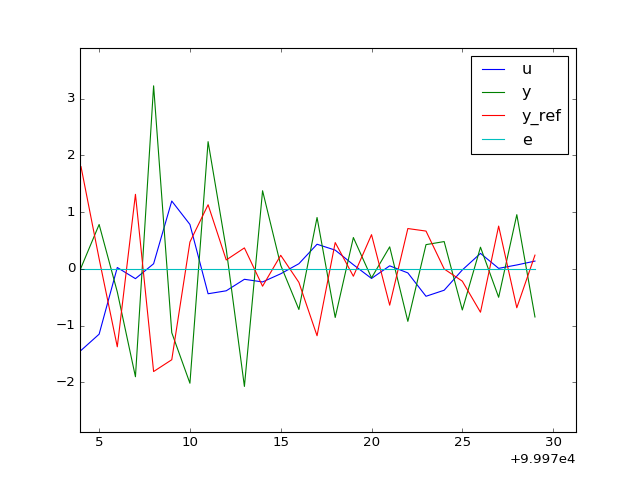

(-100, 100)

In [51]:
plt.figure()
plt.plot(u)
plt.plot(y)
plt.plot(y_ref)
plt.plot(errors)
plt.legend(['u', 'y', 'y_ref', 'e'])
plt.ylim(-100, 100)

Let's try a model reference adaptive system
-------------------------------------------

Equation:

$$D(z)U(z) = -C(z)Y(z) + f U_c(z)$$

In [125]:
mu = 0.0001
N = 100000

In [126]:
D_len = B_len
C_len = A_len

In [139]:
#omega = np.zeros(A_len + B_len - 1) # start with zeros => division by zero error
#omega = np.random.randn(A_len + B_len - 1) # start with random noise => unstable controller
#omega = np.hstack([-A[1:], B]) # start with a perfect estimate -> nothing to do for the adaptation algorithm - works
omega = np.hstack([stable_poly(C_len), stable_poly(D_len)[1:], 1]) # => start with stable and minimal phase controller - doesn't work :()

In [140]:
C = omega[:C_len]
D = np.hstack([1, omega[C_len:-1]])
f = omega[-1]

In [141]:
u = []
y = []
errors = []
y_ref = []

last = 0

z = None

for n in range(N):
    #y_ref.append(np.random.randn(1))
    #y_ref.append(50)
    
    last = last + 0.01 if last < 1 else -1
    y_ref.append(last)
    
    if n < max(A_len, B_len):
        u.append(1)
        #u.append(np.random.randn(1))
        
        #u[-1] = float(u[-1] > 0.5)
        
        y = iir_filter(u, B, A, 1, y)
        errors.append(y[-1] - y_ref[-1])
    else:
        C = omega[:C_len]
        D = np.hstack([1, omega[C_len:-1]])
        f = omega[-1]
        
        u = iir_filter(y, C, D, 1, u)
        u[-1] = u[-1] + f * y_ref[-1]
        
        #u[-1] = float(u[-1] > 0.5)
        
        y = iir_filter(u, B, A, 1, y)

        e = y[n] - y_ref[-2]

        errors.append(e)

        z_last = z
        z = np.hstack([y[n:n - C_len:-1], u[n - 1:n - D_len:-1], y_ref[-1]])
        
        if z_last is not None:
            #print(y[n], y_ref[-2], z, z_last, omega)
        
            
            omega = omega + mu / np.dot(z_last, z_last) * e * z
            
            #print(e, z, z_last, omega)
            #break
    if u[-1] > 100 or y[-1] > 100:
        break

In [142]:
C, D, A, B

(array([ 1.00060628,  1.18775685,  0.70311683]),
 array([ 1.        , -2.48129825,  3.13323356, -2.06611502,  0.71234295,
        -0.05691805,  0.00935892, -0.00905198,  0.00381046]),
 array([ 1.        ,  0.77531671,  0.3771521 ]),
 array([  1.46527098e+00,  -2.72733456e+00,   2.66855694e+00,
         -1.18901015e+00,   2.98365538e-01,   1.05748340e-02,
         -1.30880244e-04,  -1.57631446e-04,   8.44578995e-06]))

<IPython.core.display.Javascript object>


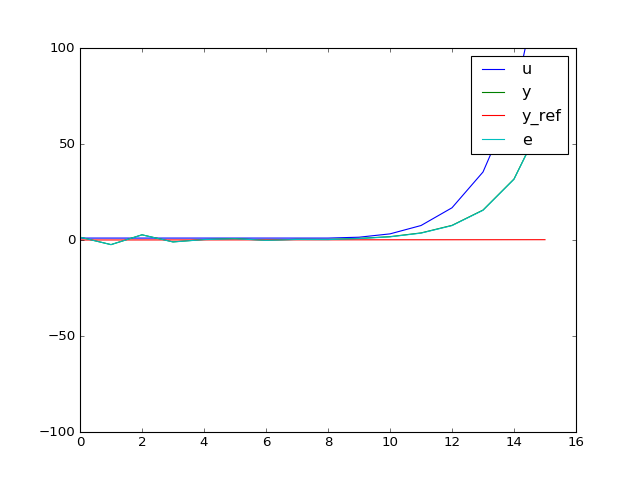

(-100, 100)

In [143]:
plt.figure()
plt.plot(u)
plt.plot(y)
plt.plot(y_ref)
plt.plot(errors)
plt.legend(['u', 'y', 'y_ref', 'e'])
plt.ylim(-100, 100)